sc22rb

Your full name:

Ritik Vinodkumar Bochiwal

### Imports

Feel free to add to this section as needed.

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np

Detect which device (CPU/GPU) to use.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The Encoder-Decoder network could be coupled and trained end-to-end, without saving features to disk; however, this requires iterating through the entire image training set during training. We can make the **training more efficient by decoupling the networks**. Thus, we will:

> First extract the feature representations of the images from the Encoder

> Save these features (Part 1) such that during the training of the Decoder (Part 3), we only need to iterate over the image feature data and the target images.


### Overview

> 1. Extracting image features
> 2. Preparation of training and validation data
> 3. Training the decoder
> 4. Generating outputs and metric graphs
> 5. Testing models on Test dataset


#1. Extracting Image Features

##1.1. ResNet Model

In [67]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-50 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        # Your code here!
        # self.resnet = torchvision.models.resnet50(pretrained=True, progress=True)
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

        # Remove the last fully-connected layer
        modules = list(self.resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        # TO COMPLETE
        # keep all layers of the pretrained net except the last layers of fully-connected ones (you are permitted to take other layers too but this can affect your accuracy!)

    def forward(self, images):
        """Extract feature vectors from input images."""

        with torch.no_grad():
          features = self.resnet(images)
          features = features.reshape(features.size(0), -1)

        return features
        # TO COMPLETE
        # remember no gradients are needed

In [68]:
# instantiate encoder and put into evaluation mode.
# Your code here!

encoder = EncoderCNN()
encoder.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

## 1.2. Image feature extraction step


In [69]:
# Get unique images from the csv for extracting features - helper code
imageList = pd.read_csv("/content/drive/MyDrive/Msc_Project/mscproject.csv")

imagesUnique = sorted(imageList['open_filename'].unique())
print(len(imagesUnique))

result_files =  pd.DataFrame.from_dict(imagesUnique)
df_id = list(sorted(imageList['id'].unique()))
result_files['id'] = df_id

df_unique_files =  pd.DataFrame.from_dict(imageList)
df_unique_files.columns = ['adj_filename','str_filename','open_filename','id']
df_unique_files['id'] = df_id
df_unique_files

1000


adj_filename      str_filename           open_filename   id
0      adj_matrix_0.png    str_elem_0.png    opening_matrix_0.png    0
1      adj_matrix_1.png    str_elem_1.png    opening_matrix_1.png    1
2      adj_matrix_2.png    str_elem_2.png    opening_matrix_2.png    2
3      adj_matrix_3.png    str_elem_3.png    opening_matrix_3.png    3
4      adj_matrix_4.png    str_elem_4.png    opening_matrix_4.png    4
..                  ...               ...                     ...  ...
995  adj_matrix_995.png  str_elem_995.png  opening_matrix_995.png  995
996  adj_matrix_996.png  str_elem_996.png  opening_matrix_996.png  996
997  adj_matrix_997.png  str_elem_997.png  opening_matrix_997.png  997
998  adj_matrix_998.png  str_elem_998.png  opening_matrix_998.png  998
999  adj_matrix_999.png  str_elem_999.png  opening_matrix_999.png  999

[1000 rows x 4 columns]

In [70]:
result_files

0   id
0      opening_matrix_0.png    0
1      opening_matrix_1.png    1
2     opening_matrix_10.png    2
3    opening_matrix_100.png    3
4    opening_matrix_101.png    4
..                      ...  ...
995  opening_matrix_995.png  995
996  opening_matrix_996.png  996
997  opening_matrix_997.png  997
998  opening_matrix_998.png  998
999  opening_matrix_999.png  999

[1000 rows x 2 columns]

In [71]:
# Define the transformations for adjacency matrix image
adj_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.9676, 0.9251, 0.9251], std=[0.1210, 0.2294, 0.2294])
])

# Define the transformations for structuring element image
str_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.9917, 0.9806, 0.9806], std=[0.0630, 0.1215, 0.1215])
])

# Define the transformations for target opening image
target_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.9593, 0.9334, 0.9334], std=[0.1348, 0.2034, 0.2034])
])

In [72]:
#This is just for adj_matrix images
from natsort import natsorted
from PIL import Image

IMAGE_DIR_adj = "/content/drive/MyDrive/Msc_Project/adjacency_matrix"

class AdjDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        adj_filename = self.df.iloc[index]['adj_filename']
        id = self.df.iloc[index]['id']
        adj_img_loc = os.path.join(IMAGE_DIR_adj, adj_filename)

        # Use PIL for image loading
        adj_image = Image.open(adj_img_loc).convert("RGB")
        # Apply the transformations
        adj_image = self.transform(adj_image)

        return adj_image, id

    def __len__(self):
        return len(self.df)

In [73]:
#This is just for str_elem images
from natsort import natsorted
from PIL import Image

IMAGE_DIR_str = "/content/drive/MyDrive/Msc_Project/structuring_elem"

class StrDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        str_filename = self.df.iloc[index]['str_filename']
        id = self.df.iloc[index]['id']
        str_img_loc = os.path.join(IMAGE_DIR_str, str_filename)

        # Use PIL for image loading
        str_image = Image.open(str_img_loc).convert("RGB")
        # Apply the transformations
        str_image = self.transform(str_image)

        return str_image, id

    def __len__(self):
        return len(self.df)

In [74]:
#This is just for target images
from natsort import natsorted
from PIL import Image

IMAGE_DIR_target = "/content/drive/MyDrive/Msc_Project/opening_result"

class TargetDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        open_filename = self.df.iloc[index]['open_filename']
        id = self.df.iloc[index]['id']
        open_img_loc = os.path.join(IMAGE_DIR_target, open_filename)

        # Use PIL for image loading
        open_image = Image.open(open_img_loc).convert("RGB")
        # Apply the transformations
        target_image = self.transform(open_image)

        return target_image, id

    def __len__(self):
        return len(self.df)

Update the values in the transformation step at the top if needed

In [12]:
from natsort import natsorted
from PIL import Image
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms

IMAGE_DIR_adj = "/content/drive/MyDrive/Msc_Project/adjacency_matrix"
IMAGE_DIR_str = "/content/drive/MyDrive/Msc_Project/structuring_elem"
IMAGE_DIR_target = "/content/drive/MyDrive/Msc_Project/opening_result"

class CombinedDataset(Dataset):
    def __init__(self, df, transform_adj, transform_str, transform_target):
        self.df = df
        self.transform_adj = transform_adj
        self.transform_str = transform_str
        self.transform_target = transform_target

    def __getitem__(self, index):
        adj_filename = self.df.iloc[index]['adj_filename']
        str_filename = self.df.iloc[index]['str_filename']
        target_filename = self.df.iloc[index]['open_filename']
        id = self.df.iloc[index]['id']
        adj_img_loc = os.path.join(IMAGE_DIR_adj, adj_filename)
        str_img_loc = os.path.join(IMAGE_DIR_str, str_filename)
        target_img_loc = os.path.join(IMAGE_DIR_target,target_filename)

        # Use PIL for image loading
        adj_image = Image.open(adj_img_loc).convert("RGB")
        str_image = Image.open(str_img_loc).convert("RGB")
        target_image = Image.open(target_img_loc).convert("RGB")

        # Apply transformations
        adj_image = self.transform_adj(adj_image)
        str_image = self.transform_str(str_image)
        target_image = self.transform_target(target_image)

        # Combine the adjacency and structuring element images into a single tensor
        # combined_image = torch.cat((adj_image, str_image), dim=0)

        return adj_image, str_image, target_image

    def __len__(self):
        return len(self.df)

Dataset for Extracting features from encoder

In [75]:
# Use Dataloader to use the unique files using the class COCOImagesDataset
# make sure that shuffle is False as we are not aiming to retrain in this exercise
# Use Dataloader to load the combined dataset
from torch.utils.data import DataLoader

adj_dataset = AdjDataset(df_unique_files, transform=adj_transform)
str_dataset = StrDataset(df_unique_files, transform=str_transform)
# combined_dataset = CombinedDataset(df_unique_files,transform_adj=adj_transform, transform_str=str_transform, transform_target= target_transform)

adj_dataloader = DataLoader(
    adj_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

str_dataloader = DataLoader(
    str_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=2
)

# combined_dataloader = DataLoader(
#     combined_dataset,
#     batch_size=64,
#     shuffle=False,
#     num_workers=2
# )

# adj_data, adj_labels = next(iter(adj_dataloader))
# str_data, str_labels = next(iter(str_dataloader))
# adj_data, str_data, target_data = next(iter(combined_dataloader))
# print(adj_data.size())
# print(str_data.size())
# print(target_data.size())
# prints shape of image with single batch

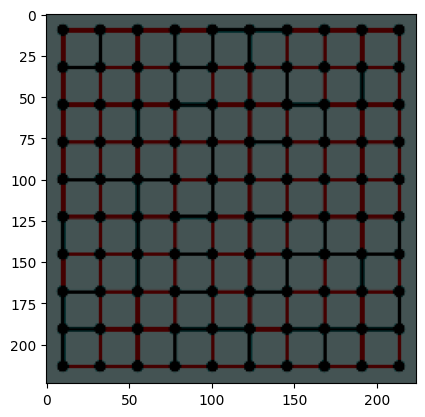

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63


In [87]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()

# get some random training images using the data loader
dataiter = iter(adj_dataloader)
images, labels = next(dataiter)

# show images and labels
timshow(torchvision.utils.make_grid(images[0]))
print(*labels.numpy())

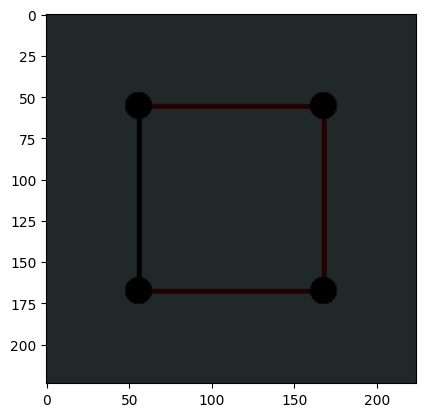

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63


In [88]:
def timshow(x):
    xa = np.transpose(x.numpy(),(1,2,0))
    plt.imshow(xa)
    plt.show()

# get some random training images using the data loader
dataiter = iter(str_dataloader)
images, labels = next(dataiter)

# show images and labels
timshow(torchvision.utils.make_grid(images[0]))
print(*labels.numpy())

In [16]:
# def timshow(x):
#     xa = np.transpose(x.numpy(),(1,2,0))
#     plt.imshow(xa)
#     plt.show()

# # get some random training images using the data loader
# dataiter = iter(combined_dataloader)
# _,_,images = next(dataiter)

# # show images and labels
# timshow(torchvision.utils.make_grid(images))

In [ ]:
# from torchsummary import summary
# summary(encoder, input_size=(3, 224, 224))

#2. Preparing training and validation set

In [76]:
# Apply encoder to extract featues and save them (e.g., you can save it using image_ids)
# Hint - make sure to save your features after running this - you can use torch.save to do this

from tqdm.notebook import tqdm
from PIL import Image

def extract_features(encoder, dataloader, device):
    features_map = dict()
    encoder.eval()
    with torch.no_grad():
        for images, ids in tqdm(dataloader):
            images = images.to(device)
            features = encoder(images)
            for i in range(images.shape[0]):
                features_map[ids.numpy()[i]] = images[i]
    return features_map


encoder.eval() # make sure the Encoder model is in evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
adj_features_map = extract_features(encoder.to(device), adj_dataloader, device)
torch.save(adj_features_map, "/content/drive/MyDrive/Msc_Project/Result/adj_features_map_nt.pt")
str_features_map = extract_features(encoder.to(device), str_dataloader, device)
torch.save(str_features_map, "/content/drive/MyDrive/Msc_Project/Result/str_features_map_nt.pt")

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

In [77]:
adj_features_map = torch.load("/content/drive/MyDrive/Msc_Project/Result/adj_features_map_nt.pt")
print(adj_features_map)

{0: tensor([[[0.2678, 0.2678, 0.2678,  ..., 0.2678, 0.2678, 0.2678],
         [0.2678, 0.2678, 0.2678,  ..., 0.2678, 0.2678, 0.2678],
         [0.2678, 0.2678, 0.2678,  ..., 0.2678, 0.2678, 0.2678],
         ...,
         [0.2678, 0.2678, 0.2678,  ..., 0.2678, 0.2678, 0.2678],
         [0.2678, 0.2678, 0.2678,  ..., 0.2678, 0.2678, 0.2678],
         [0.2678, 0.2678, 0.2678,  ..., 0.2678, 0.2678, 0.2678]],

        [[0.3265, 0.3265, 0.3265,  ..., 0.3265, 0.3265, 0.3265],
         [0.3265, 0.3265, 0.3265,  ..., 0.3265, 0.3265, 0.3265],
         [0.3265, 0.3265, 0.3265,  ..., 0.3265, 0.3265, 0.3265],
         ...,
         [0.3265, 0.3265, 0.3265,  ..., 0.3265, 0.3265, 0.3265],
         [0.3265, 0.3265, 0.3265,  ..., 0.3265, 0.3265, 0.3265],
         [0.3265, 0.3265, 0.3265,  ..., 0.3265, 0.3265, 0.3265]],

        [[0.3265, 0.3265, 0.3265,  ..., 0.3265, 0.3265, 0.3265],
         [0.3265, 0.3265, 0.3265,  ..., 0.3265, 0.3265, 0.3265],
         [0.3265, 0.3265, 0.3265,  ..., 0.3265, 0.3265

In [86]:
str_features_map = torch.load("/content/drive/MyDrive/Msc_Project/Result/str_features_map_nt.pt")
print(str_features_map)

torch.Size([3, 224, 224])


## 2.1  Split the data (3 marks)

Split the data 70/10/20% into train/validation/test sets. **Be sure that each unique image (and all corresponding captions) only appear in a single set.**

We provide the function below which, given a list of unique image IDs and a 3-split ratio, shuffles and returns  a split of the image IDs.

If using a dataframe, ```df['image_id'].unique()``` will return the list of unique image IDs.

In [19]:
import random
import math

def split_ids(image_id_list, train=.7, valid=0.1, test=0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """
    list_copy = image_id_list.copy()
    random.shuffle(list_copy)

    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)

    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

In [20]:
img_id_list = df_unique_files['id'].unique()
train_ids,val_ids,test_ids = split_ids(img_id_list)
len(train_ids),len(val_ids),len(test_ids)

(700, 100, 200)

In [21]:
train_val_ids = np.concatenate((train_ids,val_ids))
len(train_val_ids)

800

In [22]:
train_df = df_unique_files[df_unique_files['id'].isin(train_ids)]
train_df

adj_filename      str_filename           open_filename   id
0      adj_matrix_0.png    str_elem_0.png    opening_matrix_0.png    0
1      adj_matrix_1.png    str_elem_1.png    opening_matrix_1.png    1
2      adj_matrix_2.png    str_elem_2.png    opening_matrix_2.png    2
3      adj_matrix_3.png    str_elem_3.png    opening_matrix_3.png    3
4      adj_matrix_4.png    str_elem_4.png    opening_matrix_4.png    4
..                  ...               ...                     ...  ...
995  adj_matrix_995.png  str_elem_995.png  opening_matrix_995.png  995
996  adj_matrix_996.png  str_elem_996.png  opening_matrix_996.png  996
997  adj_matrix_997.png  str_elem_997.png  opening_matrix_997.png  997
998  adj_matrix_998.png  str_elem_998.png  opening_matrix_998.png  998
999  adj_matrix_999.png  str_elem_999.png  opening_matrix_999.png  999

[700 rows x 4 columns]

In [23]:
val_df = df_unique_files[df_unique_files['id'].isin(val_ids)]
val_df

adj_filename      str_filename           open_filename   id
16    adj_matrix_16.png   str_elem_16.png   opening_matrix_16.png   16
20    adj_matrix_20.png   str_elem_20.png   opening_matrix_20.png   20
21    adj_matrix_21.png   str_elem_21.png   opening_matrix_21.png   21
25    adj_matrix_25.png   str_elem_25.png   opening_matrix_25.png   25
28    adj_matrix_28.png   str_elem_28.png   opening_matrix_28.png   28
..                  ...               ...                     ...  ...
945  adj_matrix_945.png  str_elem_945.png  opening_matrix_945.png  945
966  adj_matrix_966.png  str_elem_966.png  opening_matrix_966.png  966
980  adj_matrix_980.png  str_elem_980.png  opening_matrix_980.png  980
986  adj_matrix_986.png  str_elem_986.png  opening_matrix_986.png  986
990  adj_matrix_990.png  str_elem_990.png  opening_matrix_990.png  990

[100 rows x 4 columns]

In [24]:
test_df = df_unique_files[df_unique_files['id'].isin(test_ids)]
test_df

adj_filename      str_filename           open_filename   id
23    adj_matrix_23.png   str_elem_23.png   opening_matrix_23.png   23
24    adj_matrix_24.png   str_elem_24.png   opening_matrix_24.png   24
27    adj_matrix_27.png   str_elem_27.png   opening_matrix_27.png   27
33    adj_matrix_33.png   str_elem_33.png   opening_matrix_33.png   33
43    adj_matrix_43.png   str_elem_43.png   opening_matrix_43.png   43
..                  ...               ...                     ...  ...
962  adj_matrix_962.png  str_elem_962.png  opening_matrix_962.png  962
965  adj_matrix_965.png  str_elem_965.png  opening_matrix_965.png  965
975  adj_matrix_975.png  str_elem_975.png  opening_matrix_975.png  975
981  adj_matrix_981.png  str_elem_981.png  opening_matrix_981.png  981
985  adj_matrix_985.png  str_elem_985.png  opening_matrix_985.png  985

[200 rows x 4 columns]

In [25]:
train_val_df = df_unique_files[df_unique_files['id'].isin(train_val_ids)]
train_val_df

adj_filename      str_filename           open_filename   id
0      adj_matrix_0.png    str_elem_0.png    opening_matrix_0.png    0
1      adj_matrix_1.png    str_elem_1.png    opening_matrix_1.png    1
2      adj_matrix_2.png    str_elem_2.png    opening_matrix_2.png    2
3      adj_matrix_3.png    str_elem_3.png    opening_matrix_3.png    3
4      adj_matrix_4.png    str_elem_4.png    opening_matrix_4.png    4
..                  ...               ...                     ...  ...
995  adj_matrix_995.png  str_elem_995.png  opening_matrix_995.png  995
996  adj_matrix_996.png  str_elem_996.png  opening_matrix_996.png  996
997  adj_matrix_997.png  str_elem_997.png  opening_matrix_997.png  997
998  adj_matrix_998.png  str_elem_998.png  opening_matrix_998.png  998
999  adj_matrix_999.png  str_elem_999.png  opening_matrix_999.png  999

[800 rows x 4 columns]

In [79]:
IMAGE_DIR_target = "/content/drive/MyDrive/Msc_Project/opening_result"

class Combined_Features(Dataset):
    """ COCO subset custom dataset, compatible with torch.utils.data.DataLoader. """

    def __init__(self, df, features_a, features_b,transform_target):

        self.df = df
        self.features_a = features_a
        self.features_b = features_b
        self.transform_target = transform_target

    def __getitem__(self, index):

        img_id = self.df.iloc[index]['id']
        target_filename = self.df.iloc[index]['open_filename']

         # Get image features
        features_a = self.features_a[self.df.iloc[index]['id']]
        features_b = self.features_b[self.df.iloc[index]['id']]
        target_img_loc = os.path.join(IMAGE_DIR_target,target_filename)
        target_image = Image.open(target_img_loc).convert("RGB")
        target_image = self.transform_target(target_image)

        return features_a, features_b, target_image

    def __len__(self):
        return len(self.df)


In [80]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset_train = Combined_Features(
    df=train_val_df,
    features_a=adj_features_map,
    features_b=str_features_map,
    transform_target = target_transform
)

train_dataloader = DataLoader(
    dataset_train,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

featuresa,featuresb,target_data = next(iter(train_dataloader))
print(featuresa.size())
print(featuresb.size())
print(target_data.size())


dataset_val = Combined_Features(
    df=val_df,
    features_a=adj_features_map,
    features_b=str_features_map,
    transform_target = target_transform
)

val_dataloader = DataLoader(
    dataset_val,
    batch_size=64,
    shuffle=False,
    num_workers=0
)

torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224])


In [ ]:
print(dataset_train.__getitem__(0))

(tensor([[[0.9560]],

        [[0.0000]],

        [[0.5587]],

        ...,

        [[0.4949]],

        [[0.2516]],

        [[0.3308]]]), tensor([[[1.5625]],

        [[1.8713]],

        [[0.2116]],

        ...,

        [[0.4136]],

        [[0.2951]],

        [[0.3746]]]), tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1

Load one batch of the training set and print out the shape of each returned Tensor.

In [84]:
dataiter = iter(train_dataloader)
adjfeatures,strfeatures,target_data = next(dataiter)
for i in range(0,len(adjfeatures)):
  print(adjfeatures[i].size(),strfeatures[i].size(),target_data[i].size())

torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) torch.Size([3, 224, 224])
torch.Size([3, 224, 224]) torch.Size([3, 224, 224]) torch.Size([

#3. Train RESNET

> ResNet Model

##3.1 Proposed Decoder Architecture

In [81]:
import torch
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # # Adaptive average pooling to convert the feature vector to (1, 1)
        # self.adaptive_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Bottleneck blocks in reverse order
        self.bottlenecks = nn.ModuleList([
            self._make_reverse_bottleneck(4096, 1024),
            self._make_reverse_bottleneck(1024, 512),
            self._make_reverse_bottleneck(512, 256),
            self._make_reverse_bottleneck(256,64)
        ])

        # Reverse max pooling to upsample the feature maps
        self.reverse_max_pool = nn.Upsample(scale_factor=2, mode='nearest')

        #reverse avgpooling2d
        self.unsample = nn.Upsample(size=7, mode='nearest')

        # ReLU activation in reverse
        self.relu = nn.ReLU(inplace=True)

        # Batch normalization in reverse
        self.batch_norm = nn.BatchNorm2d(64)

        # Convolutional layer to generate the final 3-channel image
        self.conv_transpose = nn.ConvTranspose2d(64, 3, kernel_size=(8, 8), stride=(2, 2), padding=(3, 3), bias=False)

    def _make_reverse_bottleneck(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels, in_channels, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=(1, 1), stride=(1, 1), bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = x.view(x.size(0), x.size(1), 1, 1)

        x = self.unsample(x)
        for bottleneck in self.bottlenecks:
            x = bottleneck(x)
            x = self.reverse_max_pool(x)

        x = self.relu(x)
        x = self.batch_norm(x)
        x = self.conv_transpose(x)

        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.decoder = Decoder()

    def forward(self, x1, x2):
        # z1 = self.encoder(x1)
        # z2 = self.encoder(x2)
        z = torch.cat((x1, x2), dim=1)  # Concatenate the encoded features
        return self.decoder(z)

3.1.2 Complex architecture

In [ ]:
# decoder = Decoder(64)
# decoder.eval()

In [ ]:
# from torchsummary import summary
# summary(decoder,input_size = (4096,1,1))

In [30]:
# Calculate Peak Signal-to-Noise Ratio (PSNR)
def calculate_psnr(original, reconstructed):
    mse = F.mse_loss(reconstructed, original)
    psnr = 10 * torch.log10(1 / mse)
    return psnr.item()

# Calculate Structural Similarity Index (SSIM)
def calculate_ssim(original, reconstructed):
    original_np = original.permute(0, 2, 3, 1).cpu().detach().numpy()
    reconstructed_np = reconstructed.permute(0, 2, 3, 1).cpu().detach().numpy()
    ssim_score = np.mean([ssim(original_np[i], reconstructed_np[i], channel_axis=2) for i in range(original_np.shape[0])])
    return ssim_score


In [82]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from skimage.metrics import structural_similarity as ssim

def train(model, device, train_dataloader, val_dataloader, num_epochs=10, learning_rate=1e-3):
    criterion = nn.MSELoss() # Mean Square Error loss (L2-norm)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    train_losses = []
    val_losses = []
    train_psnrs = []
    train_ssims = []
    val_psnrs = []
    val_ssims = []
    outputs = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_psnr_sum = 0.0
        train_ssim_sum = 0.0

        for data in train_dataloader:
            adj_img, str_img, target = data
            adj_img, str_img, target = adj_img.to(device), str_img.to(device), target.to(device)
            optimizer.zero_grad()
            recon = model(adj_img, str_img)
            # print(recon)
            loss = criterion(recon, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate PSNR and SSIM for training accuracy
            psnr = calculate_psnr(target, recon)
            ssim = calculate_ssim(target, recon)
            train_psnr_sum += psnr
            train_ssim_sum += ssim

        # Calculate average PSNR and SSIM for training accuracy
        avg_train_psnr = train_psnr_sum / len(train_dataloader)
        avg_train_ssim = train_ssim_sum / len(train_dataloader)
        train_psnrs.append(avg_train_psnr)
        train_ssims.append(avg_train_ssim)

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        val_psnr_sum = 0.0
        val_ssim_sum = 0.0

        with torch.no_grad():
            for data in val_dataloader:
                adj_img, str_img, target = data
                adj_img, str_img, target = adj_img.to(device), str_img.to(device), target.to(device)
                recon = model(adj_img, str_img)
                loss = criterion(recon, target)
                val_loss += loss.item()

                # Calculate PSNR and SSIM for training accuracy
                psnr = calculate_psnr(target, recon)
                ssim = calculate_ssim(target, recon)
                val_psnr_sum += psnr
                val_ssim_sum += ssim

        # Calculate average PSNR and SSIM for training accuracy
        avg_val_psnr = val_psnr_sum / len(val_dataloader)
        avg_val_ssim = val_ssim_sum / len(val_dataloader)
        val_psnrs.append(avg_val_psnr)
        val_ssims.append(avg_val_ssim)

        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)

        print(f'Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train PSNR: {avg_train_psnr:.2f} dB, Train SSIM: {avg_train_ssim:.4f}, '
      f'Val Loss: {val_loss:.4f}, Val PSNR: {avg_val_psnr:.2f} dB, Val SSIM: {avg_val_ssim:.4f}')

        if(epoch%5 == 0):
          outputs.append((epoch, adj_img, str_img, recon),)

    # Save the model
    torch.save(model.state_dict(), '/content/drive/MyDrive/Msc_Project/Result/ResNet/model_resnet_10_2.pth')

    # Save the outputs list
    # torch.save(outputs, '/content/drive/MyDrive/Msc_Project/Result/ResNet/outputs_resnet_10.pth')

    metrics = [train_losses,val_losses,train_psnrs,val_psnrs,train_ssims,val_ssims,epoch]

    torch.save(metrics, '/content/drive/MyDrive/Msc_Project/Result/ResNet/metrics_resnet_10_2.pth')

    return outputs, models, metrics

In [83]:
 # note we have 64-dim fixed inside the Autoencoder - try to change and see what happens
model = Autoencoder().to(device)
max_epochs = 30
outputs, model, metrics = train(model, device, train_dataloader, val_dataloader, num_epochs=max_epochs)

RuntimeError: ignored

In [55]:
import matplotlib.pyplot as plt

def show_output(outputs, metrics):

  train_losses = metrics[0]
  val_losses = metrics[1]
  train_psnrs = metrics[2]
  val_psnrs = metrics[3]
  train_ssims = metrics[4]
  val_ssims = metrics[5]
  max_epochs = 9

  # counter_list = list(range(0, max_epochs + 1,2))
  # # Look at different epochs to see how reconstruction has worked
  # for k in counter_list:
  #     print(k)
  #     adj_img = outputs[k][1].to('cpu').detach()
  #     str_img = outputs[k][2].to('cpu').detach()
  #     recon = outputs[k][3].to('cpu').detach()

  #     for i, item in enumerate(adj_img[0]):
  #         if i >= 1: break
  #         # enhance_brightness(adj_img[0])
  #         timshow(torchvision.utils.make_grid(adj_img[0]))
  #         # plt.subplot(3, 9, i + 1)
  #         # plt.imshow(item[0])

  #     for i, item in enumerate(str_img[0]):
  #         if i >= 1: break
  #         # enhance_brightness(str_img[0])
  #         timshow(torchvision.utils.make_grid(str_img[0]))

  #     for i, item in enumerate(recon[0]):
  #         if i >= 1: break
  #         # enhance_brightness(recon[0])
  #         timshow(torchvision.utils.make_grid(recon[0]))

  # Plot the graph
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 3, 1)
  plt.plot(range(0, max_epochs + 1), train_losses, label='Train Loss')
  plt.plot(range(0, max_epochs + 1), val_losses, label='Val Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 3, 2)
  plt.plot(range(0, max_epochs + 1), train_psnrs, label='Train PSNR')
  plt.plot(range(0, max_epochs + 1), val_psnrs, label='Val PSNR')
  plt.xlabel('Epoch')
  plt.ylabel('PSNR (db)')
  plt.legend()

  plt.subplot(1, 3, 3)
  plt.plot(range(0, max_epochs + 1), train_ssims, label='Train SSIM')
  plt.plot(range(0, max_epochs + 1), val_ssims, label='Val SSIM')
  plt.xlabel('Epoch')
  plt.ylabel('SSIM')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
#for resnet model
import matplotlib.pyplot as plt

def show_output(max_epochs,outputs, metrics):

  train_losses = metrics[0]
  val_losses = metrics[1]
  train_psnrs = metrics[2]
  val_psnrs = metrics[3]
  train_ssims = metrics[4]
  val_ssims = metrics[5]

  counter_list = list(range(0, max_epochs + 1,5))
  # Look at different epochs to see how reconstruction has worked
  for k in ,:
      print(k)
      # adj_img = outputs[k][1].to('cpu').detach()
      # str_img = outputs[k][2].to('cpu').detach()
      recon = outputs[k][3].to('cpu').detach()

      # for i, item in enumerate(adj_img[0]):
      #     if i >= 1: break
      #     # enhance_brightness(adj_img[0])
      #     # timshow(torchvision.utils.make_grid(adj_img[0]))
      #     # plt.subplot(3, 9, i + 1)
      #     # plt.imshow(item[0])

      # for i, item in enumerate(str_img[0]):
      #     if i >= 1: break
      #     # enhance_brightness(str_img[0])
      #     # timshow(torchvision.utils.make_grid(str_img[0]))

      for i, item in enumerate(recon[0]):
          if i >= 1: break
          # enhance_brightness(recon[0])
          timshow(torchvision.utils.make_grid(recon[0]))

  # Plot the graph
  plt.figure(figsize=(12, 6))
  plt.subplot(1, 3, 1)
  plt.plot(range(0, max_epochs + 1), train_losses, label='Train Loss')
  plt.plot(range(0, max_epochs + 1), val_losses, label='Val Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 3, 2)
  plt.plot(range(0, max_epochs + 1), train_psnrs, label='Train PSNR')
  plt.plot(range(0, max_epochs + 1), val_psnrs, label='Val PSNR')
  plt.xlabel('Epoch')
  plt.ylabel('PSNR (db)')
  plt.legend()

  plt.subplot(1, 3, 3)
  plt.plot(range(0, max_epochs + 1), train_ssims, label='Train SSIM')
  plt.plot(range(0, max_epochs + 1), val_ssims, label='Val SSIM')
  plt.xlabel('Epoch')
  plt.ylabel('SSIM')
  plt.legend()

  plt.tight_layout()
  plt.show()

# **Outputs**

1. Basic model

Resnet Model

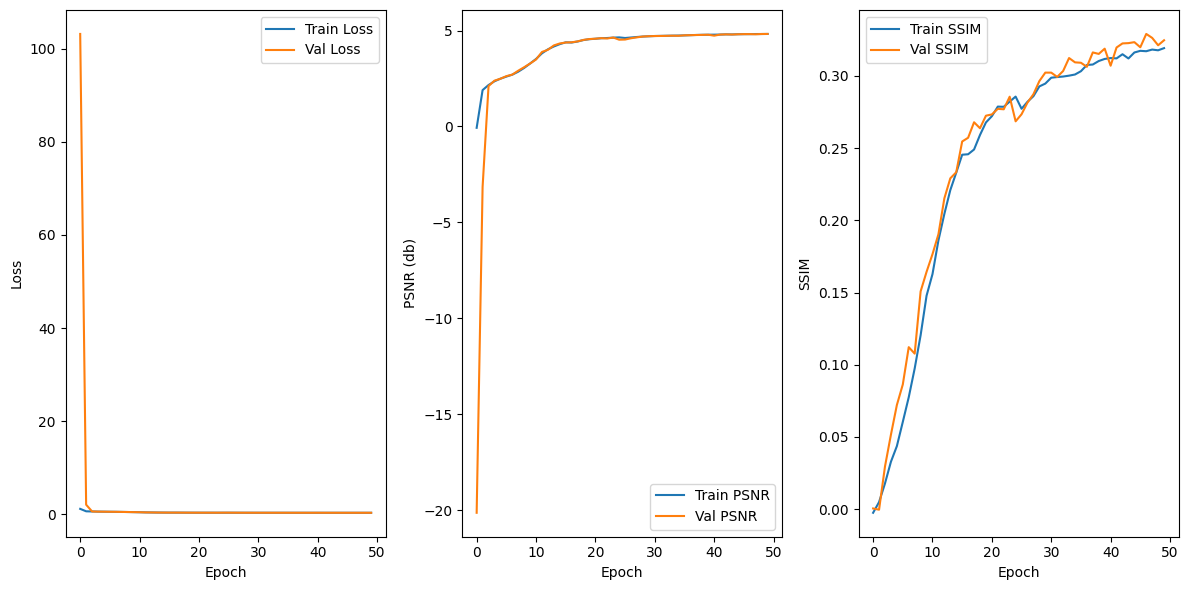

In [54]:
#print output of resnet model
output_tensor = torch.load('/content/drive/MyDrive/Msc_Project/Result/ResNet/outputs_resnet_10.pth')
metrics = torch.load('/content/drive/MyDrive/Msc_Project/Result/ResNet/metrics_resnet_10.pth')

show_output(outputs = output_tensor, metrics = metrics)

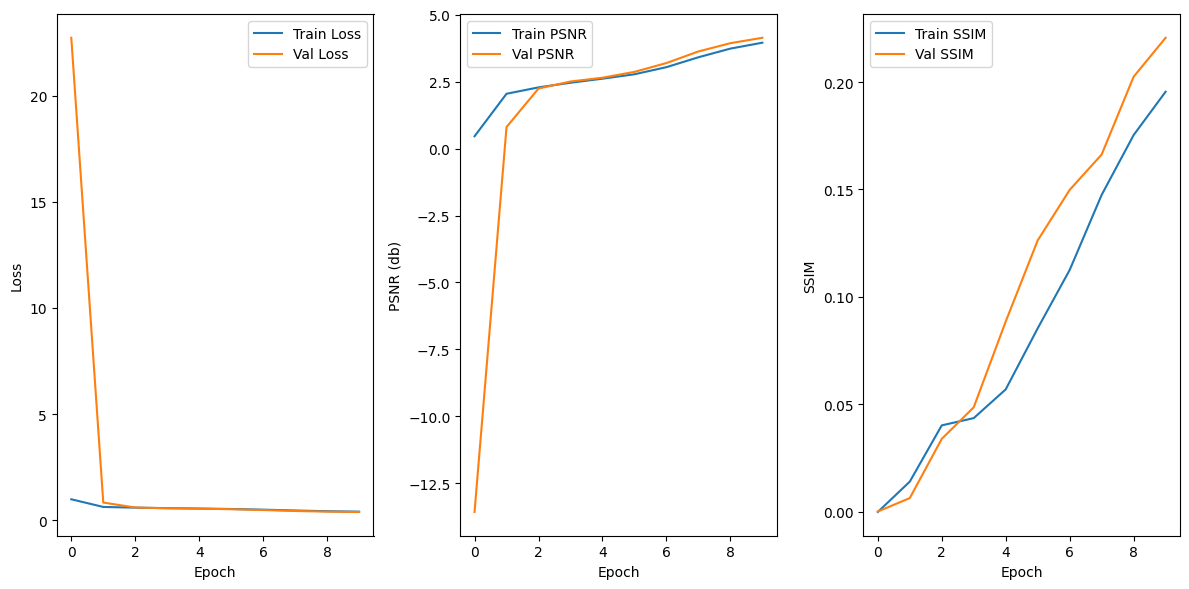

In [57]:
#print output of resnet model
# output_tensor = torch.load('/content/drive/MyDrive/Msc_Project/Result/ResNet/outputs_resnet_10_2.pth')
metrics = torch.load('/content/drive/MyDrive/Msc_Project/Result/ResNet/metrics_resnet_10_2.pth')

show_output(outputs = output_tensor, metrics = metrics)

In [58]:
adj_inv_transform = transforms.Compose([ transforms.Normalize(mean = [-0.9676/0.1210, -0.9251/0.2294, -0.9251/0.2294],
                                                     std = [1/0.1210, 1/0.2294, 1/0.2294]),
                               ])

str_inv_transform = transforms.Compose([ transforms.Normalize(mean = [-0.9917/0.0630, -0.9806/0.1215, -0.9806/0.1215],
                                                     std = [1/0.0630, 1/0.1215, 1/0.1215]),
                               ])

target_inv_transform = transforms.Compose([ transforms.Normalize(mean = [-0.9593/0.1348, -0.9334/0.2034, -0.9334/0.2034],
                                                     std = [1/0.1348, 1/0.2034, 1/0.2034]),
                               ])

In [59]:
from google.colab.patches import cv2_imshow
import skimage.exposure
import cv2
def brightness(image):
  image = np.transpose(image.numpy(),(1,2,0))
  image = np.clip(image, 0, 1)  # Clip values to [0, 1] range
  image = (image * 255).astype(np.uint8)
  result = image.copy()

  hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
  # cv2_imshow(hsv_image)
  # plt.imshow(hsv_image)
  # plt.show()
  # Define lower and upper bounds for red color in HSV
  lower_red = np.array([0, 50, 50])
  upper_red = np.array([20, 255, 255])

  # Define lower and upper bounds for black color in HSV
  lower_black = np.array([0, 0, 0])
  upper_black = np.array([180, 255, 30])

  # Create masks for red and black color pixels
  red_mask = cv2.inRange(hsv_image, lower_red, upper_red)
  black_mask = cv2.inRange(hsv_image, lower_black, upper_black)
  # cv2_imshow(red_mask)
  # cv2_imshow(black_mask)

  # Apply the masks to the original image to enhance the colors
  red_highlighted = cv2.bitwise_and(result, result, mask=red_mask)
  # black_highlighted = cv2.bitwise_and(image, image, mask=black_mask)
  # cv2_imshow(red_highlighted)

  # plt.imshow(red_highlighted)
  # plt.show()

  return red_highlighted

In [60]:
def test(model, device, test_dataloader):
    model.eval()
    outputs = []

    with torch.no_grad():
        for data in test_dataloader:
            adj_img, str_img, target = data
            adj_img, str_img, target = adj_img.to(device), str_img.to(device), target.to(device)
            recon = model(adj_img, str_img)
            outputs.append((adj_img, str_img, recon, target))
    return outputs

In [61]:
from torch.utils.data import DataLoader

dataset_test = Combined_Features(
    df=test_df,
    features_a=adj_features_map,
    features_b=str_features_map,
    transform_target = target_transform
)

test_dataloader = DataLoader(
    dataset_test,
    batch_size=64,
    shuffle=False,
    num_workers=0
)

In [62]:
print(len(test_dataloader))

4


In [63]:
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from PIL import Image
def test_output(test_outputs):
  counter_list = list(range(0, len(test_dataloader)))

  #to capture metrics
  test_psnr_sum = 0.0
  test_ssim_sum = 0.0
  for k in range(len(counter_list)):
        print(k)
        adj_img = test_outputs[k][0].to('cpu').detach()
        str_img = test_outputs[k][1].to('cpu').detach()
        recon = test_outputs[k][2].to('cpu').detach()
        open = test_outputs[k][3].to('cpu').detach()

        # for i, item in enumerate(adj_img[0]):
        #     if i >= 1: break
        #     # enhance_brightness(adj_img[0])
        #     inv_adj_image = adj_inv_transform(adj_img[0])
        #     timshow(torchvision.utils.make_grid(inv_adj_image))
        #     hsv_adj = brightness(torchvision.utils.make_grid(inv_adj_image))
        #     # plt.subplot(3, 9, i + 1)
        #     # plt.imshow(item[0])

        # for i, item in enumerate(str_img[0]):
        #     if i >= 1: break
        #     # enhance_brightness(str_img[0])
        #     inv_str_image = str_inv_transform(str_img[0])
        #     timshow(torchvision.utils.make_grid(inv_str_image))
        #     hsv_str = brightness(torchvision.utils.make_grid(inv_str_image))

        inv_recon = []
        for i in range(recon.shape[0]):
            # enhance_brightness(recon[0])
            inv_target_image = target_inv_transform(recon[i])
            # Pass only the first image to timshow_test
            if(i==0):
              timshow(torchvision.utils.make_grid(inv_target_image))
            hsv_recon = brightness(torchvision.utils.make_grid(inv_target_image))
            if(i==0):
              plt.imshow(hsv_recon)
              plt.show()
            inv_recon.append(inv_target_image)
        inv_recon = torch.stack(inv_recon, dim=0)

        inv_open = []
        for i in range(open.shape[0]):
            inv_open_image = target_inv_transform(open[i])
            # Pass only the first image to timshow_test
            if i == 0:
              timshow(torchvision.utils.make_grid(inv_open_image))
            hsv_open = brightness(torchvision.utils.make_grid(inv_open_image))
            if(i==0):
              plt.imshow(hsv_open)
              plt.show()
            inv_open.append(inv_open_image)
        inv_open = torch.stack(inv_open, dim=0)

        print(inv_open.shape, inv_recon.shape)
        print(open.shape,recon.shape)

        # Calculate PSNR and SSIM for test accuracy
        psnr = calculate_psnr(inv_open, inv_recon)
        ssim = calculate_ssim(inv_open, inv_recon)
        test_psnr_sum += psnr
        test_ssim_sum += ssim

  # Calculate average PSNR and SSIM for test accuracy
  avg_test_psnr = test_psnr_sum / len(test_dataloader)
  avg_test_ssim = test_ssim_sum / len(test_dataloader)

  print("Avg Test PSNR", avg_test_psnr)
  print("Avg Test SSIM", avg_test_ssim)

0


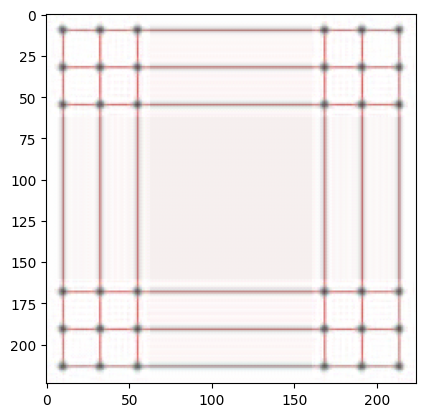

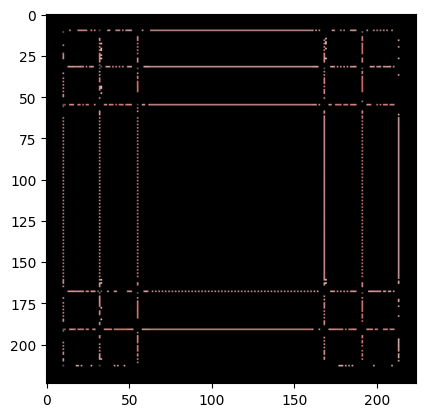

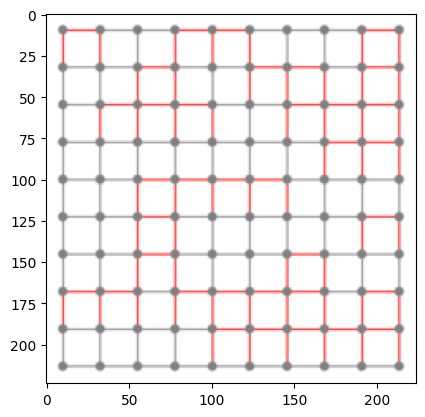

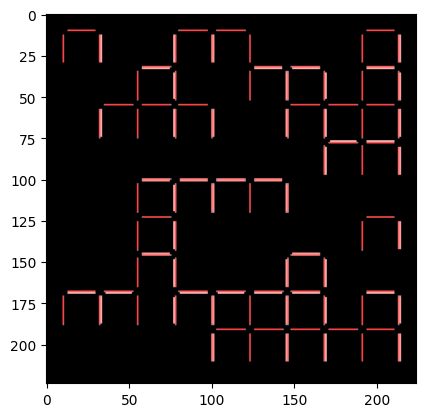

torch.Size([64, 3, 224, 224]) torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224]) torch.Size([64, 3, 224, 224])


1


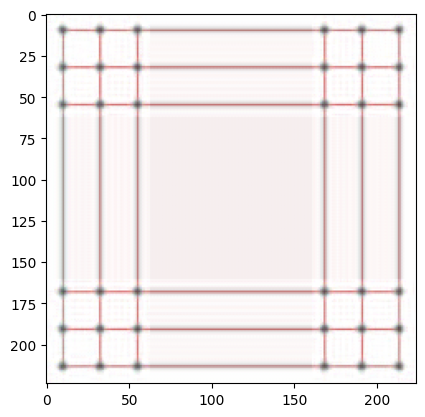

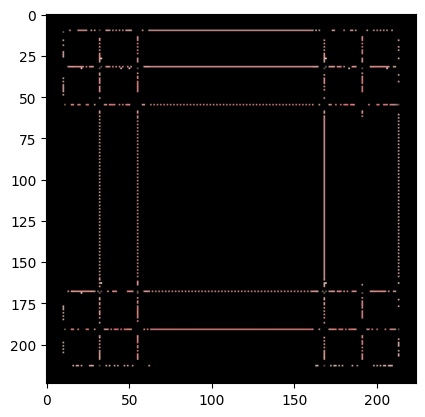

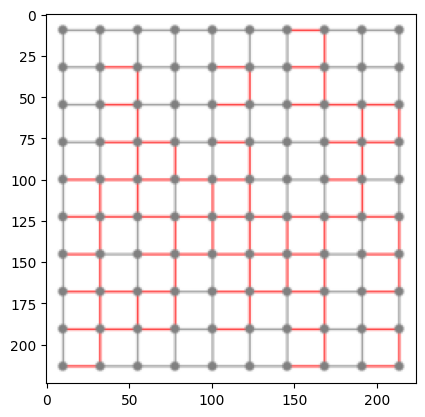

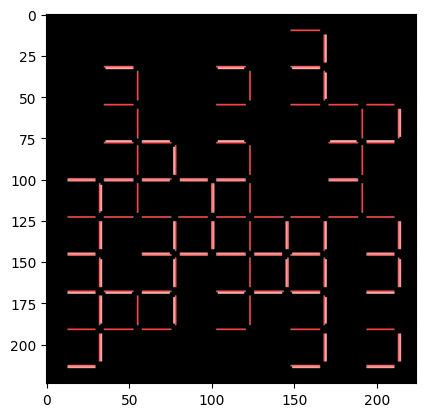

torch.Size([64, 3, 224, 224]) torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224]) torch.Size([64, 3, 224, 224])


2


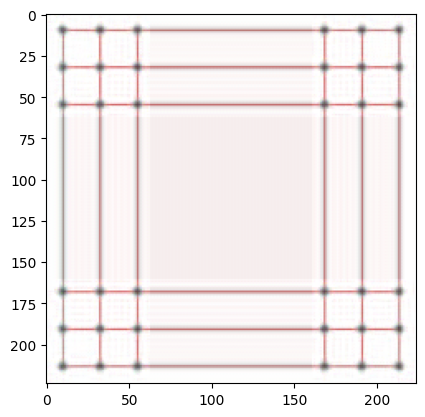

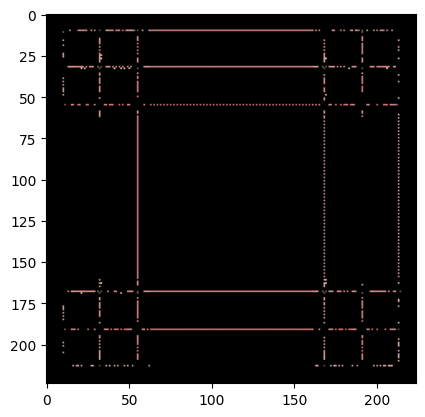

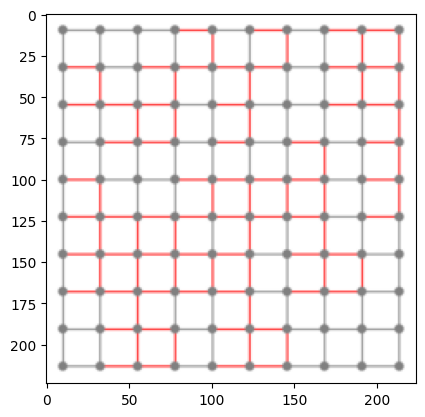

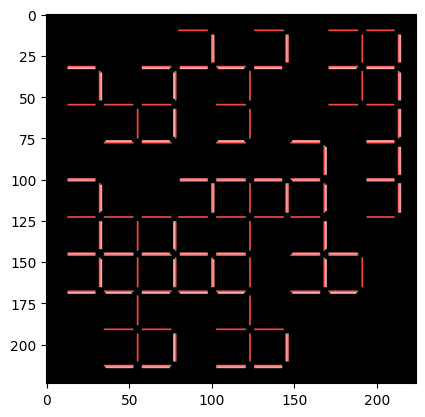

torch.Size([64, 3, 224, 224]) torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224]) torch.Size([64, 3, 224, 224])


3


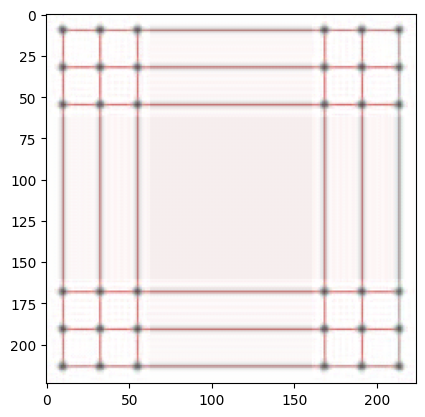

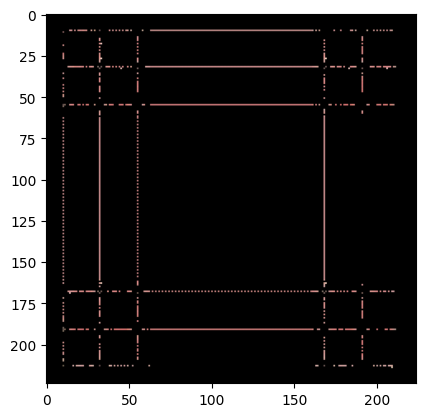

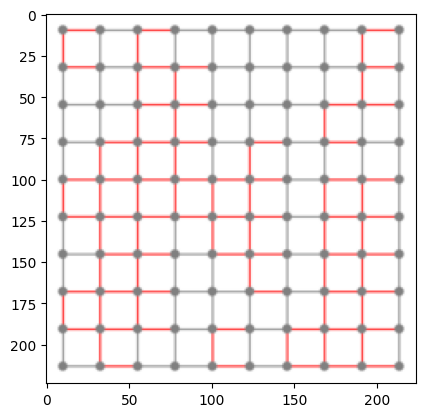

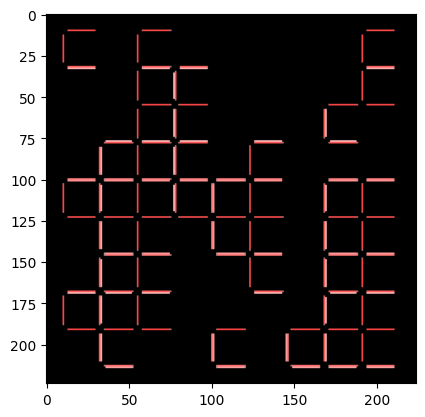

torch.Size([8, 3, 224, 224]) torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224]) torch.Size([8, 3, 224, 224])
Avg Test PSNR 19.808226585388184
Avg Test SSIM 0.7483544200658798


In [65]:
model = Autoencoder()
model.load_state_dict(torch.load('/content/drive/MyDrive/Msc_Project/Result/ResNet/model_resnet_10.pth'))
model = model.to(device)

# Call the test function
test_outputs = test(model, device, test_dataloader)
# Save the test outputs
torch.save(test_outputs, '/content/drive/MyDrive/Msc_Project/Result/ResNet/test_resnt_10.pth')
test_output(test_outputs)

0


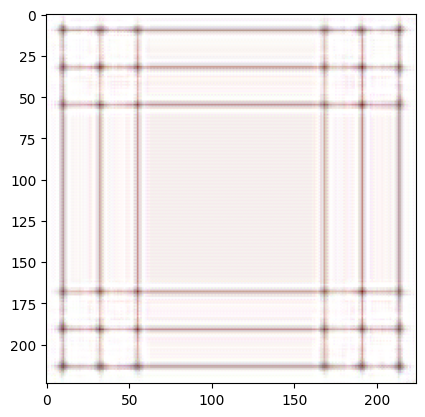

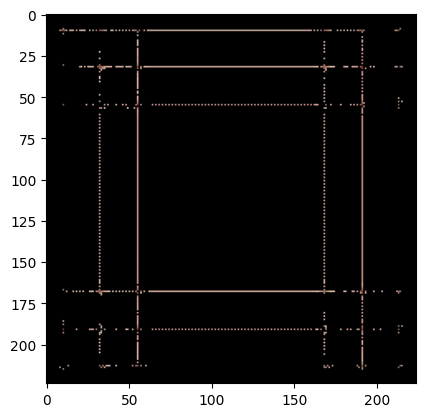

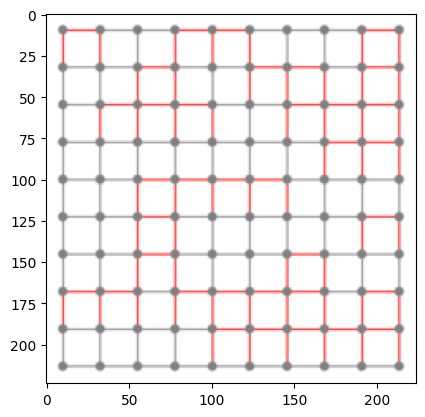

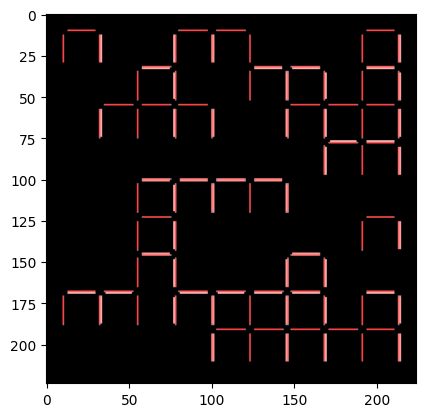

torch.Size([64, 3, 224, 224]) torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224]) torch.Size([64, 3, 224, 224])


1


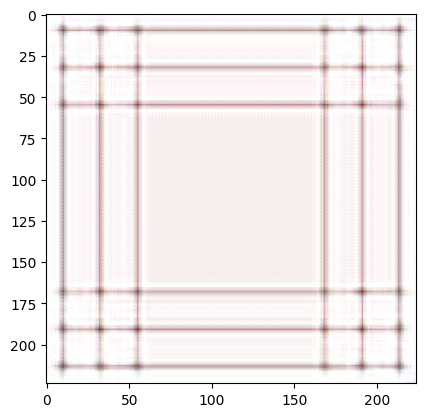

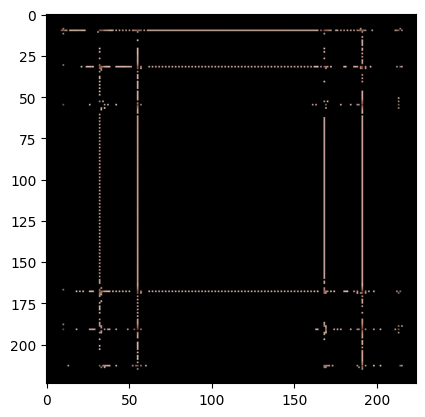

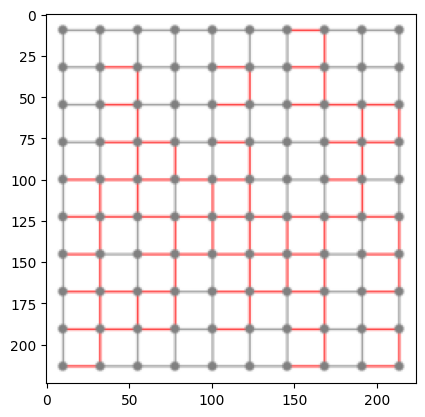

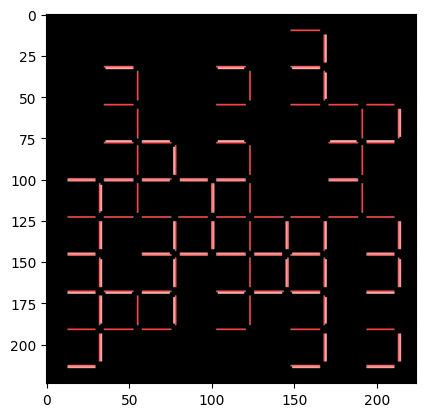

torch.Size([64, 3, 224, 224]) torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224]) torch.Size([64, 3, 224, 224])


2


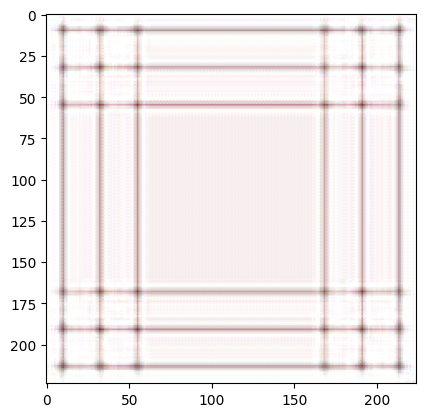

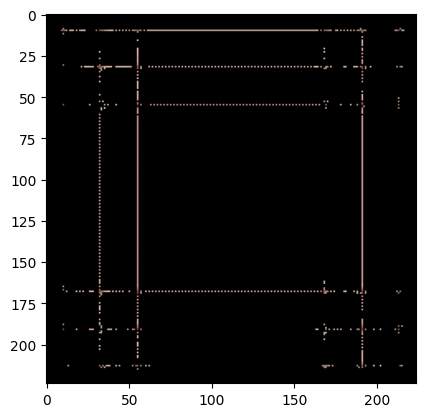

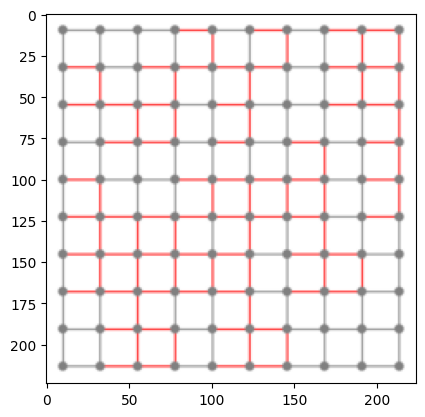

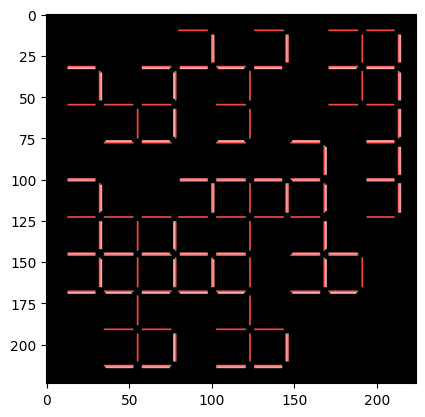

torch.Size([64, 3, 224, 224]) torch.Size([64, 3, 224, 224])
torch.Size([64, 3, 224, 224]) torch.Size([64, 3, 224, 224])


3


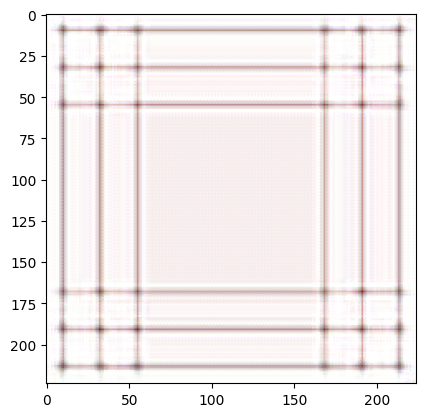

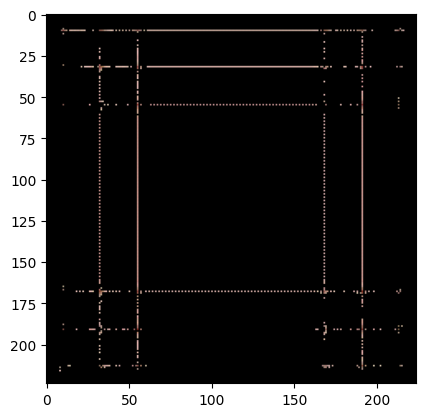

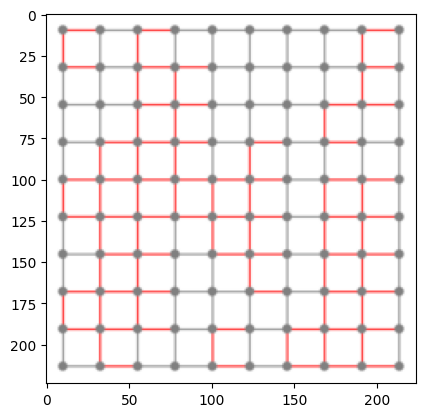

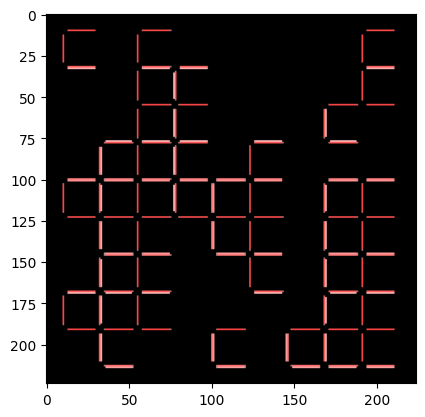

torch.Size([8, 3, 224, 224]) torch.Size([8, 3, 224, 224])
torch.Size([8, 3, 224, 224]) torch.Size([8, 3, 224, 224])
Avg Test PSNR 18.874797344207764
Avg Test SSIM 0.6624910831451416


In [66]:
model = Autoencoder()
model.load_state_dict(torch.load('/content/drive/MyDrive/Msc_Project/Result/ResNet/model_resnet_10_2.pth'))
model = model.to(device)

# Call the test function
test_outputs = test(model, device, test_dataloader)
# Save the test outputs
torch.save(test_outputs, '/content/drive/MyDrive/Msc_Project/Result/ResNet/test_resnt_10_2.pth')
test_output(test_outputs)

#### 3.2 Variational Autoencoders

1st approach:

Concatenating Images before Encoding (Current Approach):

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(6, 32, 5, stride=2, padding=2)  # Concatenate two images along the channel dimension
        self.activation = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 5, stride=2, padding=2)
        self.conv_mu = nn.Conv2d(64, latent_dims, 7)
        self.conv_var = nn.Conv2d(64, latent_dims, 7)
        self.training = True

    def sample(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x1, x2):
        x = torch.cat((x1, x2), dim=1)  # Concatenate the two images along the channel dimension
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        mu = self.conv_mu(x)
        log_var = self.conv_var(x)

        if self.training:
            x = self.sample(mu, log_var)
        else:
            x = mu

        return x, mu, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dims, 64, 7),  # Use latent_dims as the number of channels
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 5, stride=2, padding=2, output_padding=1),
            nn.Tanh()  # Try using Tanh as the final activation function
        )

    def forward(self, x):
        x = self.decoder(x)
        return x

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x1, x2):
        z, mu, log_var = self.encoder(x1, x2)  # Pass both images to the encoder
        img_reconstruct = self.decoder(z)
        return img_reconstruct, mu, log_var

In [ ]:
# Define a KL-divegence loss
def kl_loss(mu, log_var):
  KLD      = - 0.5 * torch.sum(1+ log_var - mu.pow(2) - log_var.exp())
  return KLD

# Alternative to MSE, you can also use BCE (binary cross entropy)
BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mu, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mu.pow(2) - log_var.exp())
    return reproduction_loss + KLD

In [ ]:
def train_VAE(model, device, num_epochs=5, learning_rate=1e-4, print_on=True):
    criterion = nn.MSELoss() # mean square error loss (l2-norm)
    beta = 1.0 # set a weight to balance between two losses
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate,
                                 weight_decay=1e-5)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_dataloader:
            adj_img, str_img, target = data
            recon, mu, log_var = model(adj_img.to(device), str_img.to(device))
            # loss1 = criterion(recon, img.to(device)) # MSE loss as before
            # loss2 = kl_loss(mu, log_var) # added KL-divergence loss
            # loss = loss1 + beta * loss2
            loss = loss_function(target.to(device), recon, mu, log_var)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        if print_on:
          print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, adj_img, str_img, recon),)

    # Save the model
    torch.save(model.state_dict(), '/content/drive/MyDrive/Msc_Project/Result/vae_model_64_50.pth')

    # Save the outputs list
    torch.save(outputs, '/content/drive/MyDrive/Msc_Project/Result/vae_outputs_64_50.pth')

    return outputs, model

In [ ]:
latent_dims = 2
model_VAE = VariationalAutoencoder(latent_dims).to(device)
max_epochs = 50
outputs_VAE, model_VAE = train_VAE(model_VAE, device, num_epochs=max_epochs, print_on=True)

RuntimeError: ignored

In [ ]:
learning_rate = 0.001
num_epochs = 20
result_dir = '/content/drive/MyDrive/DeepLearning_2/Result/'
patience = 10

import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch import LongTensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(train_decoder.parameters(), lr=learning_rate)

# set the decoder to training mode
train_decoder.train()


# train the decoder
total_step = len(train_dataloader)
for epoch in range(num_epochs):
    correct = 0          # number of examples predicted correctly (for accuracy)
    total = 0            # number of examples
    running_loss = 0.0   # accumulated loss (for mean loss)
    n = 0                # number of minibatches
    val_correct = 0
    val_samples = 0
    val_running_loss = 0
    for i, (features, captions, lengths) in enumerate(train_dataloader):
        # move inputs and targets to GPU if available
        features = features.to(device)
        captions = captions.to(device)
        lengths = lengths.to(device)
        # print(captions)
        # print(features.shape)
        # print(lengths)

        #arrange captions in descending order
        lengths, perm_idx = lengths.sort(0, descending=True)
        captions = captions[perm_idx]
        features = features[perm_idx]
        # print(captions)
        # print(lengths)


        packed_captions = pack_padded_sequence(captions, lengths.cpu(), batch_first = True).to(device)[0]
        # # Assuming targets is a tensor with shape (batch_size, max_caption_length)
        print(packed_captions.shape)

        # forward pass
        one_hot_targets = F.one_hot(packed_captions, num_classes=len(train_val_vocab))
        # print(one_hot_targets.shape)
        targets, _ = pad_packed_sequence(pack_padded_sequence(one_hot_targets, lengths.cpu(), batch_first=True))
        targets = targets.transpose(0, 1)
        # print(targets.shape)
        train_decoder.to(device)
        resize = nn.Linear(2048, 256)
        resize.to(device)
        im_features = resize(features)
        # print(im_features.shape)
        bn = nn.BatchNorm1d(256, momentum=0.01)
        bn.to(device)
        im_features = bn(im_features.squeeze(1))
        print(im_features.shape)
        embed = nn.Embedding(len(train_vocab), 256)
        embed.to(device)
        embeddings = embed(captions.squeeze(1))
        print(embeddings.size())
        embeddings = torch.cat((im_features, embeddings), dim=1)
        print(embeddings.size())
        print(embeddings)
        # packed = pack_padded_sequence(embeddings, lengths.cpu(), batch_first=True, enforce_sorted=False).to(device)
        # print(packed[0])
        if(i==0):
          break

        outputs = train_decoder(features, captions, lengths.cpu())
        print(outputs.shape)
        # Pad zeros to the end of outputs tensor
        # pad_length = one_hot_targets.shape[1] - outputs.shape[1]
        # padded_outputs = F.pad(outputs, (0, 0, 0, pad_length), value=0)
        # print(pad_length)
        # print(padded_outputs.shape)
        # # Calculate the loss
        # print(outputs.reshape(-1).shape)
        # print(targets.reshape(-1).shape)
        loss = criterion(outputs.float(), packed_captions.float())
        # loss = criterion(outputs, one_hot_targets)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accumulate loss
        running_loss += loss.item()
        n += 1

        # compute training accuracy
        predicted_captions = torch.argmax(outputs, dim=-1)
        # print(predicted_captions.shape)
        predicted_captions_flat = predicted_captions.view(-1)
        # print(predicted_captions_flat.shape)
        targets_flat = targets.reshape(-1, targets.shape[-1])
        # print(targets_flat.shape)
        correct += (predicted_captions_flat == targets_flat.argmax(dim=-1)).sum().item()
        total += targets_flat.shape[0]
    training_accuracy = correct / total

    # print training statistics
    print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Training_loss: {running_loss/n:.4f}, Training_accuracy: {training_accuracy:.4f}')

    # save checkpoint
    torch.save(train_decoder.state_dict(), result_dir + f'checkpoint_{epoch+1}_{num_epochs}.pth')

    n = 0
    # evaluate on validation set
    with torch.no_grad():
        for features, captions, lengths in val_dataloader:
            # move inputs and targets to GPU if available
            features = features.to(device)
            captions = captions.to(device)
            lengths = lengths.to(device)

            lengths, perm_idx = lengths.sort(0, descending=True)
            captions = captions[perm_idx]
            features = features[perm_idx]

            packed_captions = pack_padded_sequence(captions, lengths.cpu(), batch_first = True).to(device)[0]
            # # Assuming targets is a tensor with shape (batch_size, max_caption_length)
            # print(packed_captions.shape)

            # forward pass
            one_hot_targets = F.one_hot(packed_captions, num_classes=len(train_val_vocab))
            # print(one_hot_targets.shape)
            targets, _ = pad_packed_sequence(pack_padded_sequence(one_hot_targets, lengths.cpu(), batch_first=True))
            targets = targets.transpose(0, 1)

            val_decoder.to(device)

            # forward pass
            outputs = val_decoder(features, captions, lengths.cpu())
            loss = criterion(outputs.float(), targets.float())

            # accumulate validation loss
            val_running_loss += loss.item()
            n += 1

            # compute training accuracy
            predicted_captions = torch.argmax(outputs, dim=-1)
            # print(predicted_captions.shape)
            predicted_captions_flat = predicted_captions.view(-1)
            # print(predicted_captions_flat.shape)
            targets_flat = targets.reshape(-1, targets.shape[-1])
            # print(targets_flat.shape)
            val_correct += (predicted_captions_flat == targets_flat.argmax(dim=-1)).sum().item()
            val_samples += targets_flat.shape[0]

        avg_val_loss = val_running_loss / n
        val_accuracy = val_correct / val_samples
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # save best model
    best_val_loss = 100000.00
    if avg_val_loss < best_val_loss:
        torch.save(val_decoder.state_dict(), '/content/drive/MyDrive/DeepLearning_2/Result/best_model.pth')
        best_val_loss = avg_val_loss

    # early stopping
    if epoch > patience and avg_val_loss >= best_val_loss:
        print(f'Validation loss did not improve for {patience} epochs. Stopping early.')
        break

# # plot training and validation loss
# import matplotlib.pyplot as plt
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.legend()
# plt.show()

RuntimeError: ignored

## 4 Generate predictions on test data [8 marks]

Display 5 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

In [ ]:
# Load test data
dataset_test = COCO_Features(
    df=test_df,
    vocab=train_val_vocab,
    features=features_map,
)

test_dataloader = DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0
)

# load the saved model state dictionary
train_decoder.load_state_dict(torch.load('/content/drive/MyDrive/DeepLearning_2/Result/best_model.pth'))

# move the model to the same device used during training
train_decoder.to(device)

# set the model in evaluation mode
train_decoder.eval()

with torch.no_grad():
    for i, (features, captions, lengths) in enumerate(test_dataloader):
        # move the features to the same device used during training
        features = features.to(device)

        # resize = nn.Linear(2048, 256).to(device)
        # bn = nn.BatchNorm1d(256, momentum=0.01).to(device)
        # print(features.shape)
        # x = resize(features)
        # print(x.squeeze(1).shape)
        # print(bn(x.squeeze(1)).shape)
        # you will have to double squeeze as we need to remove both 1s ig
        # inputs = bn(x.squeeze(1))
        # generate captions using the sample method of the decoder
        sampled_ids = train_decoder.sample(features)

        # convert the sampled ids to captions using the vocabulary
        captions = []
        for sampled_id in sampled_ids:
            caption = []
            for word_id in sampled_id:
                word = train_val_vocab.idx2word[word_id.item()]
                if word == '<end>':
                    break
                if word != '<start>' and word != '<pad>':
                    caption.append(word)
            caption = ' '.join(caption)
            captions.append(caption)

        # display the images and their generated captions
        image_path = test_df.iloc[i]['file_path']
        image = Image.open(image_path)
        plt.imshow(image)
        plt.title(captions[0])
        plt.axis('off')
        plt.show()

## 5 Caption evaluation using BLEU score [10 marks]

There are different methods for measuring the performance of image to text models. We will evaluate our model by measuring the text similarity between the generated caption and the reference captions, using two commonly used methods. Ther first method is known as *Bilingual Evaluation Understudy (BLEU)*.

> 5.1 Average BLEU score on all data (5 marks)

> 5.2 Examplaire high and low score BLEU score samples (5 marks, at least two)

####  5.1 Average BLEU score on all data (5 marks)


One common way of comparing a generated text to a reference text is using BLEU. This article gives a good intuition to how the BLEU score is computed: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/, and you may find an implementation online to use. One option is the NLTK implementation `nltk.translate.bleu_score` here: https://www.nltk.org/api/nltk.translate.bleu_score.html


> **Tip:** BLEU scores can be weighted by ith-gram. Check that your scores make sense; and feel free to use a weighting that best matches the data. We will not be looking for specific score ranges; rather we will check that the scores are reasonable and meaningful given the captions.

Write the code to evaluate the trained model on the complete test set and calculate the BLEU score using the predictions, compared against all five references captions.

Display a histogram of the distribution of scores over the test set.

In [ ]:
# TO COMPLETE
from nltk.translate.bleu_score import sentence_bleu
stats = pd.DataFrame(columns=['ref','preds','bleu','cos_sim'])#dict()

# --> Your code here!





In [ ]:
print("Average BLEU score:", stats['bleu'].mean())
ax = stats['bleu'].plot.hist(bins=100, alpha=0.5)

#### 5.2 Examplaire high and low score BLEU score samples (5 marks)

Find one sample with high BLEU score and one with a low score, and display the model's predicted sentences, the BLEU scores, and the 5 reference captions.

In [ ]:
# TO COMPLETE

## 6 Caption evaluation using cosine similarity [12 marks]

> 6.1 Cosine similarity (6 marks)

> 6.2 Cosine similarity examples (6 marks)

####  6.1 Cosine similarity (6 marks)

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions:

* Find the embedding vector of each word in the caption
* Compute the average vector for each caption
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores

Calculate the cosine similarity using the model's predictions over the whole test set.

Display a histogram of the distribution of scores over the test set.

In [ ]:
# TO COMPLETE

#### 6.2 Cosine similarity examples (6 marks)

Find one sample with high cosine similarity score and one with a low score, and display the model's predicted sentences, the cosine similarity scores, and the 5 reference captions.

In [ ]:
# TO COMPLETE

## 7 Comparing BLEU and Cosine similarity [16 marks]

> 7.1 Test set distribution of scores (6 marks)

> 7.2 Analysis of individual examples (10 marks)

#### 7.1 Test set distribution of scores (6 marks)

Compare the model’s performance on the test set evaluated using BLEU and cosine similarity and discuss some weaknesses and strengths of each method (explain in words, in a text box below).

Please note, to compare the average test scores, you need to rescale the Cosine similarity scores [-1 to 1] to match the range of BLEU method [0.0 - 1.0].

In [ ]:
# TO COMPLETE

 #### 7.2 Analysis of individual examples (10 marks)

Find and display one example where both methods give similar scores and another example where they do not and discuss. Include both scores, predicted captions, and reference captions.

In [ ]:
# TO COMPLETE